## Helper functions

In [1]:
from cot import Collection

In [2]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [3]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [4]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [28]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [6]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [7]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [8]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [9]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [10]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [11]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_item_plot(scores_per_objective):  #later better axes
 
    data = scores_per_objective
    averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
    sorted_data = {k: v for k, v in sorted(averaged_data.items())}

    # Extract the keys (objectives) and values (averages) from the sorted dictionary
    keys = sorted_data.keys()
    values = sorted_data.values()

    # Create a bar plot
    plt.bar(keys, values)
    plt.xlabel('Objectives')
    plt.ylabel('Average')
    # plt.ylim(7,10)
    plt.title('Average per Objective')
    plt.xticks(rotation=45)
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))

In [12]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [13]:
def t_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        t_stat, p_val = ttest_ind(dict_1[key], dict_2[key])
        print(f"For {key}, t-statistic is {t_stat:.2f} and the p-value is {p_val:.2f}")

In [14]:
from scipy.stats import mannwhitneyu

def u_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

## Data

In [21]:
from cot import Collection
med_qa_100 = Collection.from_json("./med_qa_100_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
med_qa_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
med_qa_500 = med_qa_100.merge(med_qa_400)
med_qa_500

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [22]:
# len(med_qa_400['med_qa']['test'][0]['generated_cot'])

2

In [24]:
med_qa_500

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [39]:
dataset = 'med_qa'
split = 'test'
item_correct = []
for item in med_qa_100[dataset][split]:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])
len(item_correct)
print(item_correct.count(True))
print(item_correct.count(False))


58
37


In [40]:
dataset = 'med_qa'
split = 'test'
item_correct = []
for item in med_qa_400[dataset][split]:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])
len(item_correct)
print(item_correct.count(True))
print(item_correct.count(False))

236
141


In [51]:
dataset = 'med_qa'
split = 'test'
item_correct = []
for item in med_qa_500[dataset][split]:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])
len(item_correct)
for item in item_correct:
    if item != True and item != False:
        print(item)

294
178
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [52]:
print(item_correct.count(True))
print(item_correct.count(False))

294
178


In [42]:
med_qa_400 = med_qa_400.filter(lambda ex: ex['id'] not in med_qa_100)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
med_qa_400

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    400 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [46]:
med_qa_100['med_qa']['test'][0]['generated_cot'][0]['answers'][0]['correct_answer']

True

In [47]:
med_qa_400['med_qa']['test'][0]['generated_cot'][0]['answers'][0]['correct_answer']

True

## Evaluate Reflection

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


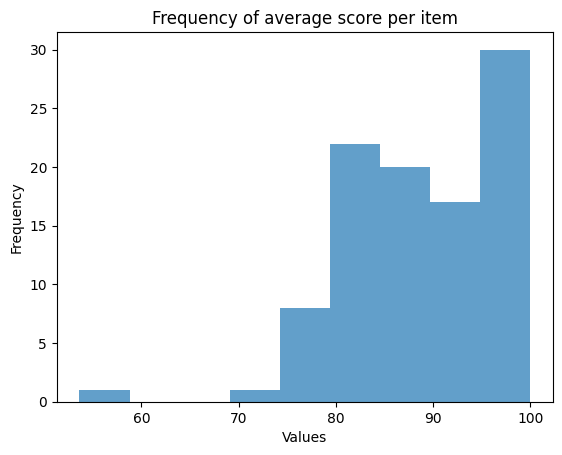

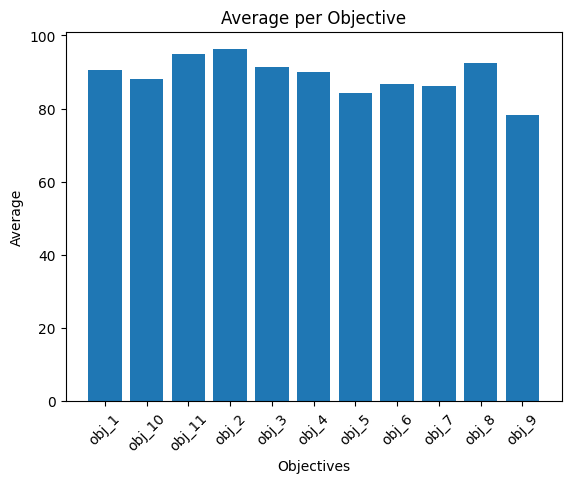

{'obj_7': (50, 100), 'obj_1': (50, 100), 'obj_9': (40, 100), 'obj_10': (50, 100), 'obj_4': (50, 100), 'obj_8': (60, 100), 'obj_3': (50, 100), 'obj_6': (50, 100), 'obj_2': (60, 100), 'obj_11': (0, 100), 'obj_5': (50, 100)}
{'obj_7': 11.754900906453967, 'obj_1': 10.103820985932504, 'obj_9': 12.62598845301168, 'obj_10': 9.441200165489128, 'obj_4': 9.271828890074005, 'obj_8': 7.770412037752322, 'obj_3': 9.485311801471786, 'obj_6': 9.982462461357615, 'obj_2': 5.9907852004623585, 'obj_11': 12.807343028770916, 'obj_5': 12.17739761093177}
For obj_7, U-statistic is 1392.00 and the p-value is 0.13
For obj_1, U-statistic is 1175.00 and the p-value is 0.92
For obj_9, U-statistic is 1282.50 and the p-value is 0.49
For obj_10, U-statistic is 1295.50 and the p-value is 0.43
For obj_4, U-statistic is 1209.00 and the p-value is 0.88
For obj_8, U-statistic is 1383.50 and the p-value is 0.14
For obj_3, U-statistic is 1416.50 and the p-value is 0.09
For obj_6, U-statistic is 1224.00 and the p-value is 0.8

In [29]:
data = med_qa_100
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

wrong output found
          Average
obj_1   88.878866
obj_2   95.399485
obj_3   90.244845
obj_4   87.641753
obj_5   82.074742
obj_6   85.141753
obj_7   84.033505
obj_8   91.481959
obj_9   77.010309
obj_10  86.881443
obj_11  94.948454
scores true: 88.2939787485242
scores false: 86.60972785176607


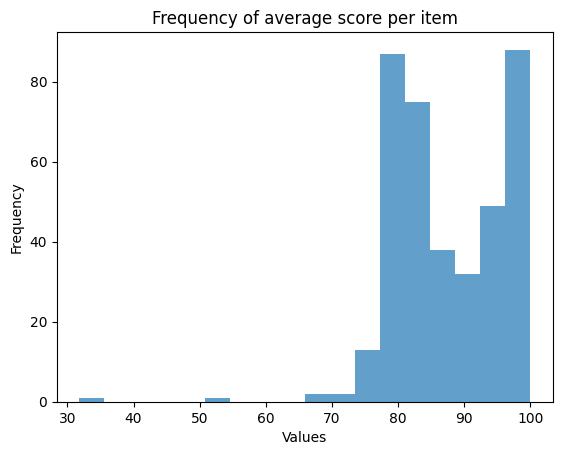

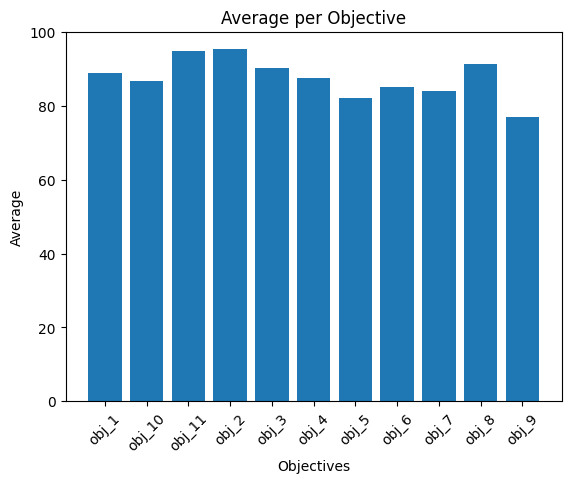

{'obj_7': (50, 100), 'obj_1': (50, 100), 'obj_9': (0, 100), 'obj_10': (50, 100), 'obj_4': (0, 100), 'obj_8': (0, 100), 'obj_3': (50, 100), 'obj_6': (50, 100), 'obj_2': (50, 100), 'obj_11': (0, 100), 'obj_5': (50, 100)}
{'obj_7': 12.385137841854249, 'obj_1': 9.689935467105503, 'obj_9': 13.160896465276684, 'obj_10': 9.28678124658062, 'obj_4': 10.524636239793159, 'obj_8': 8.659936819287815, 'obj_3': 9.711835089358658, 'obj_6': 10.00222244144176, 'obj_2': 6.01743373686309, 'obj_11': 9.078891819614393, 'obj_5': 12.237405324687476}
For obj_7, U-statistic is 18679.00 and the p-value is 0.60
For obj_1, U-statistic is 20060.50 and the p-value is 0.06
For obj_9, U-statistic is 18831.50 and the p-value is 0.50
For obj_10, U-statistic is 19441.50 and the p-value is 0.20
For obj_4, U-statistic is 20207.00 and the p-value is 0.04
For obj_8, U-statistic is 20166.50 and the p-value is 0.04
For obj_3, U-statistic is 20019.00 and the p-value is 0.07
For obj_6, U-statistic is 18943.00 and the p-value is 

In [33]:
data = med_qa_400
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

wrong output found
          Average
obj_1   89.199179
obj_2   95.574949
obj_3   90.451745
obj_4   88.131417
obj_5   82.535934
obj_6   85.472279
obj_7   84.466119
obj_8   91.663244
obj_9   77.248460
obj_10  87.125257
obj_11  94.948665
scores true: 87.85827020202021
scores false: 87.9419826404751


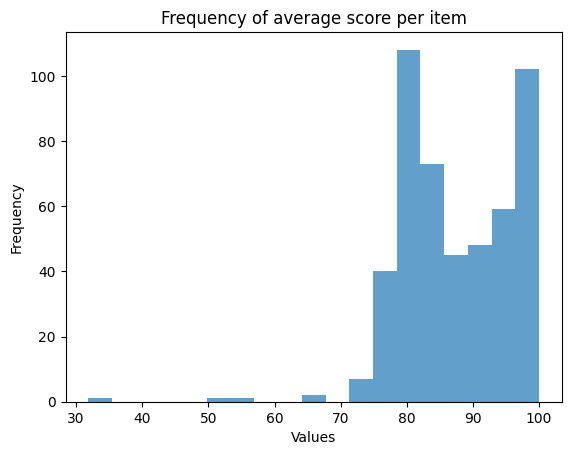

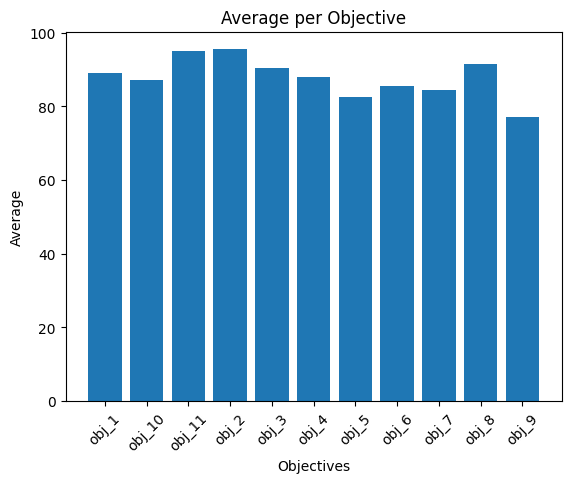

{'obj_7': (50, 100), 'obj_1': (50, 100), 'obj_9': (0, 100), 'obj_10': (50, 100), 'obj_4': (0, 100), 'obj_8': (0, 100), 'obj_3': (50, 100), 'obj_6': (50, 100), 'obj_2': (50, 100), 'obj_11': (0, 100), 'obj_5': (50, 100)}
{'obj_7': 12.277751882417183, 'obj_1': 9.785527197543535, 'obj_9': 13.049678452195582, 'obj_10': 9.321129515144495, 'obj_4': 10.318945511330442, 'obj_8': 8.486587344813966, 'obj_3': 9.66524212752038, 'obj_6': 10.009396384782459, 'obj_2': 6.015927825384887, 'obj_11': 9.935358629438705, 'obj_5': 12.246870865141155}
For obj_7, U-statistic is 29647.50 and the p-value is 0.50
For obj_1, U-statistic is 26733.50 and the p-value is 0.18
For obj_9, U-statistic is 29405.00 and the p-value is 0.61
For obj_10, U-statistic is 29019.00 and the p-value is 0.80
For obj_4, U-statistic is 27594.00 and the p-value is 0.47
For obj_8, U-statistic is 29112.50 and the p-value is 0.75
For obj_3, U-statistic is 29522.00 and the p-value is 0.55
For obj_6, U-statistic is 28672.00 and the p-value i

In [50]:
data = med_qa_500
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


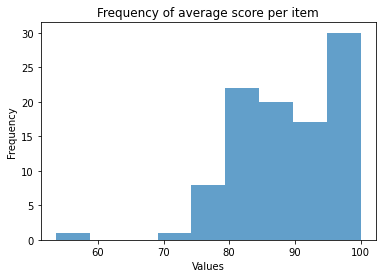

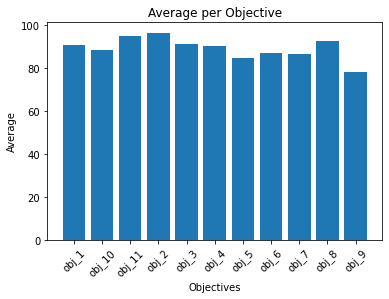

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [72]:
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


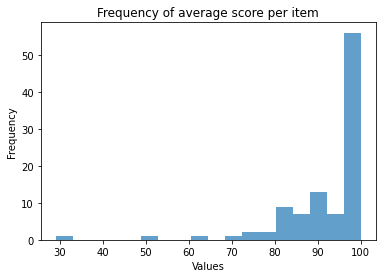

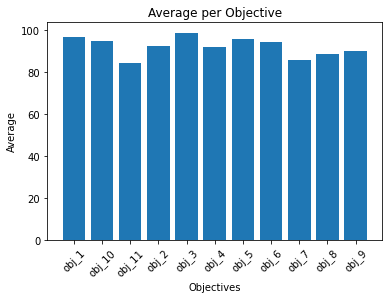

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [142]:
#note idx-2 
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     99.45
obj_2     98.30
obj_3    100.00
obj_4     98.20
obj_5     99.50
obj_6     98.30
obj_7     90.50
obj_8     97.95
obj_9     93.90
obj_10    99.15
obj_11    98.50
scores true: 97.96857463524131
scores false: 96.10047846889952


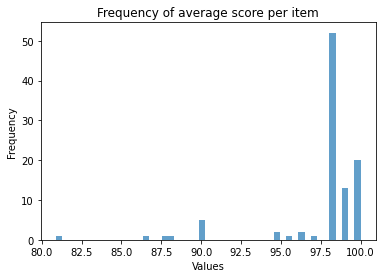

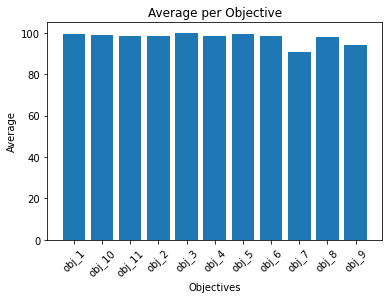

{'obj_6': (70, 100), 'obj_8': (70, 100), 'obj_4': (70, 100), 'obj_2': (70, 100), 'obj_9': (70, 100), 'obj_5': (90, 100), 'obj_7': (60, 100), 'obj_10': (80, 100), 'obj_1': (90, 100), 'obj_11': (50, 100), 'obj_3': (100, 100)}
{'obj_6': 5.135536717202729, 'obj_8': 5.90732296784801, 'obj_4': 5.389852043470677, 'obj_2': 5.135536717202729, 'obj_9': 5.84220105194208, 'obj_5': 2.190429135575903, 'obj_7': 7.571210756756962, 'obj_10': 3.557251804980975, 'obj_1': 2.2355032425551866, 'obj_11': 7.571210756756962, 'obj_3': 0.0}
For obj_6, t-statistic is 2.98 and the p-value is 0.00
For obj_8, t-statistic is 1.79 and the p-value is 0.08
For obj_4, t-statistic is 2.21 and the p-value is 0.03
For obj_2, t-statistic is 2.43 and the p-value is 0.02
For obj_9, t-statistic is 0.18 and the p-value is 0.86
For obj_5, t-statistic is 2.44 and the p-value is 0.02
For obj_7, t-statistic is 2.40 and the p-value is 0.02
For obj_10, t-statistic is 2.10 and the p-value is 0.04
For obj_1, t-statistic is 2.28 and the 

In [74]:
# Very low p-values - what is going on? Either mistake in code or a real difference?
data = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     59.00
obj_2     75.50
obj_3     59.10
obj_4     52.15
obj_5     55.70
obj_6     55.05
obj_7     52.05
obj_8     60.00
obj_9     36.60
obj_10    58.70
obj_11    63.50
scores true: 61.81818181818182
scores false: 54.779411764705884


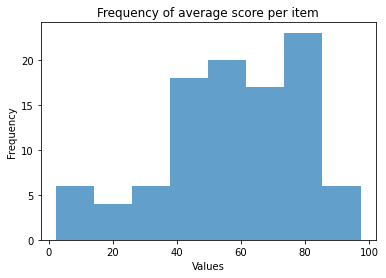

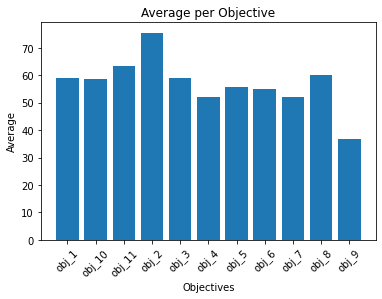

{'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_2': (25, 100), 'obj_9': (0, 80), 'obj_5': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_1': (0, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 22.24172755080965, 'obj_8': 25.34608929251695, 'obj_4': 23.871023387692382, 'obj_2': 18.16729217716567, 'obj_9': 25.848040779161803, 'obj_5': 19.18832768096062, 'obj_7': 21.20242743869034, 'obj_10': 21.551207517318968, 'obj_1': 23.148619523820116, 'obj_11': 35.230123703467406, 'obj_3': 27.278770374254627}
For obj_6, t-statistic is 1.24 and the p-value is 0.22
For obj_8, t-statistic is 1.97 and the p-value is 0.05
For obj_4, t-statistic is 1.59 and the p-value is 0.11
For obj_2, t-statistic is 0.81 and the p-value is 0.42
For obj_9, t-statistic is 1.24 and the p-value is 0.22
For obj_5, t-statistic is 0.75 and the p-value is 0.45
For obj_7, t-statistic is 1.16 and the p-value is 0.25
For obj_10, t-statistic is 1.42 and the p-value is 0.16
For obj_1, t-statistic is 1.41

In [78]:
data = Collection.from_json("./med_qa_second_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


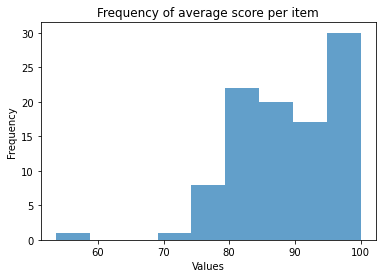

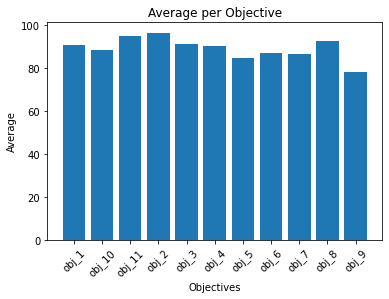

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [75]:
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


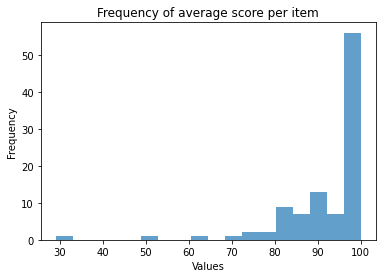

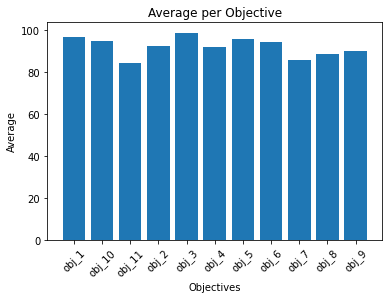

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [143]:
#note idx_cot
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      5.19
obj_2      6.48
obj_3      5.61
obj_4      4.29
obj_5      4.81
obj_6      5.08
obj_7      4.47
obj_8      5.46
obj_9      3.28
obj_10     5.04
obj_11     5.50
scores true: 5.3352272727272725
scores false: 4.870320855614973


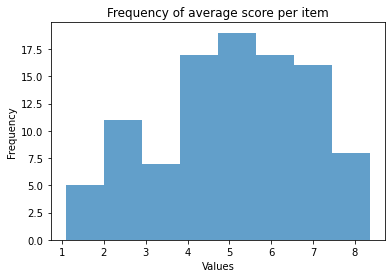

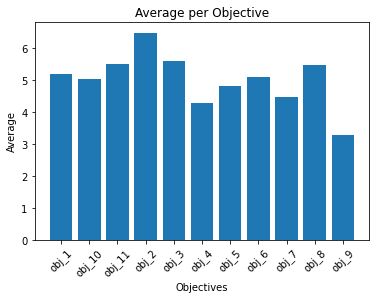

{'obj_6': (2, 8), 'obj_8': (1, 9), 'obj_4': (1, 9), 'obj_2': (2, 10), 'obj_9': (0, 7), 'obj_5': (1, 8), 'obj_7': (1, 8), 'obj_10': (1, 8), 'obj_1': (2, 8), 'obj_11': (0, 10), 'obj_3': (0, 9)}
{'obj_6': 1.6798268309019782, 'obj_8': 2.2175607675046374, 'obj_4': 1.881837700577054, 'obj_2': 2.1200343050397685, 'obj_9': 1.7001485377769348, 'obj_5': 1.4612503294276875, 'obj_7': 1.6603212540549697, 'obj_10': 1.8744426781140449, 'obj_1': 2.0631201240995747, 'obj_11': 2.886751345948129, 'obj_3': 2.1456792383623875}
For obj_6, t-statistic is 0.69 and the p-value is 0.49
For obj_8, t-statistic is 1.69 and the p-value is 0.09
For obj_4, t-statistic is 0.88 and the p-value is 0.38
For obj_2, t-statistic is 1.08 and the p-value is 0.28
For obj_9, t-statistic is 1.14 and the p-value is 0.26
For obj_5, t-statistic is 0.30 and the p-value is 0.76
For obj_7, t-statistic is 0.51 and the p-value is 0.61
For obj_10, t-statistic is 1.00 and the p-value is 0.32
For obj_1, t-statistic is 0.61 and the p-value 

In [139]:
data = Collection.from_json("./med_qa_third_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=5,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      8.11
obj_2      9.32
obj_3      8.44
obj_4      8.34
obj_5      7.47
obj_6      8.09
obj_7      7.90
obj_8      8.95
obj_9      7.06
obj_10     8.19
obj_11     9.09
scores true: 8.33228840125392
scores false: 8.181818181818182


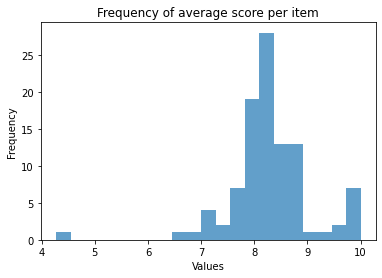

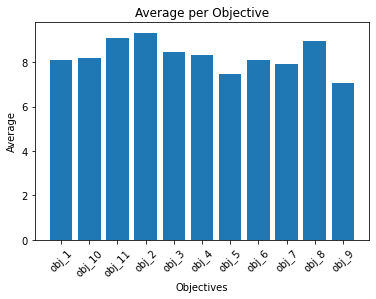

{'obj_6': (4, 10), 'obj_8': (5, 10), 'obj_4': (5, 10), 'obj_2': (6, 10), 'obj_9': (2, 10), 'obj_5': (4, 10), 'obj_7': (4, 10), 'obj_10': (3, 10), 'obj_1': (4, 10), 'obj_11': (5, 10), 'obj_3': (3, 10)}
{'obj_6': 0.888705789222721, 'obj_8': 0.7571210756756955, 'obj_4': 0.9235417115264979, 'obj_2': 0.6798692684790385, 'obj_9': 1.2294369245777328, 'obj_5': 1.0679443105822752, 'obj_7': 1.077782984471439, 'obj_10': 0.960797227895311, 'obj_1': 0.8027100562117262, 'obj_11': 0.9111542241585777, 'obj_3': 0.9777318630174611}
For obj_6, t-statistic is 1.32 and the p-value is 0.19
For obj_8, t-statistic is -0.03 and the p-value is 0.98
For obj_4, t-statistic is 0.72 and the p-value is 0.47
For obj_2, t-statistic is 1.33 and the p-value is 0.19
For obj_9, t-statistic is 0.41 and the p-value is 0.68
For obj_5, t-statistic is 0.71 and the p-value is 0.48
For obj_7, t-statistic is 1.47 and the p-value is 0.14
For obj_10, t-statistic is -0.00 and the p-value is 1.00
For obj_1, t-statistic is 0.41 and th

In [141]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=6,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [100]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=.4, power=0.9, alpha=0.05,ratio=0.67)
sample_size

164.84701057007064

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


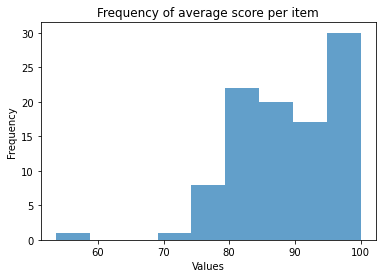

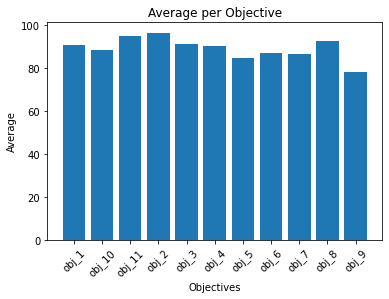

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [88]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [ ]:
# Average objective score
# Average item score (variance,span) - finding outliers?
# average objectives/item scores per true and false answers
# split range up for true, false?

## GPT-SW3

In [61]:
import requests
import os

API_URL = "https://api-inference.huggingface.co/models/AI-Sweden-Models/gpt-sw3-1.3b-instruct"
headers = {"Authorization": "Bearer "+os.environ["HUGGINGFACEHUB_API_TOKEN"]}


def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()
	
output = query({
	"inputs": "Can you please let us know more details about your ",
})

In [62]:
output

{'error': 'Model AI-Sweden-Models/gpt-sw3-1.3b-instruct is currently loading',
 'estimated_time': 20.0}

In [63]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Initialize Variables
model_name = "AI-Sweden-Models/gpt-sw3-1.3b-instruct"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
prompt = "Träd är fina för att"

# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
model.to(device)

ModuleNotFoundError: No module named 'torch'